In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
from collections import namedtuple
from copy import copy
from glob import glob
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor, get_aeff_and_binnings
from resolution import get_energy_psf_grid
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator, splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import BASEPATH, ngc1068, plt, sns
from tools import array_source_interp, get_mids
from tqdm import tqdm


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [3]:
savepath = "/".join(
    glob(BASEPATH + "/*/energy_smearing_rgi_up.pckl")[0].split("/")[:-1]
)
print(savepath)

e_smearing_files = sorted(glob(join(savepath, "[!HE]*nergy_smearing_rgi_up.pckl")))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)


/home/lisajsch/repos/Plenum/local


In [6]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [7]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [8]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [9]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
        bounds_error=False,
        fill_value=-10,
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))
    aeff_2d[k][np.isnan(aeff_2d[k])] = 0


80 log_10(energy) bins
90 declination bins


# Background

In [10]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
bckg_vals = np.exp(rgi((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [11]:
# energy smearing matrix
with open(join(savepath, "energy_smearing_rgi_up.pckl"), "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
baseline_eres = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
baseline_eres = baseline_eres / np.sum(baseline_eres, axis=0)

# artificial, improved smearing matrix
with open(join(savepath, "improved_0.5_artificial_energy_smearing_rgi_up.pckl"), "rb") as f:
    rgi = pickle.load(f)
improved_eres = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_eres = improved_eres / np.sum(improved_eres, axis=0)


# PSF-Energy 2D grid
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [12]:
# psi² representation
# analysis region in distance to source
delta_psi_max = 3

bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
# make sure the grids are correctly normalized
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl


### Plot Energy Psi

Text(0.5, 0, 'log10(E/GeV)')

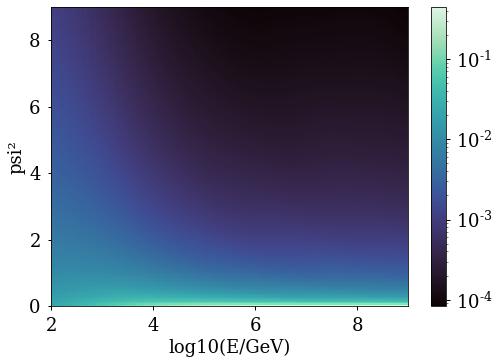

In [13]:
plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

# Flux definition

In [14]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [15]:

lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600 # livetime of 10yr PS data
LIVETIME = lt_kde = 3186 * 24 * 3600 # new ngc paper
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(savepath, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt(join(savepath, "tenyr_paper_68_contour.txt"))

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [16]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [17]:
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~80


ngc 1068: 84.4162843142101


## PL+Cut: source parameters

In [18]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


### scale the fluxes such that the event numbers match


In [19]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4271729213706608
flux normalization before 5e-14 after 7.135864606853304e-14


### Plot 1D analysis slice histograms

# source $\nu_\mu$ : 84.4
# atmo. $\nu_\mu$ : 1156.9 (within 28 deg²)
# source $\nu_\mu$ : 84.4
# atmo. $\nu_\mu$ : 1156.9 (within 28 deg²)


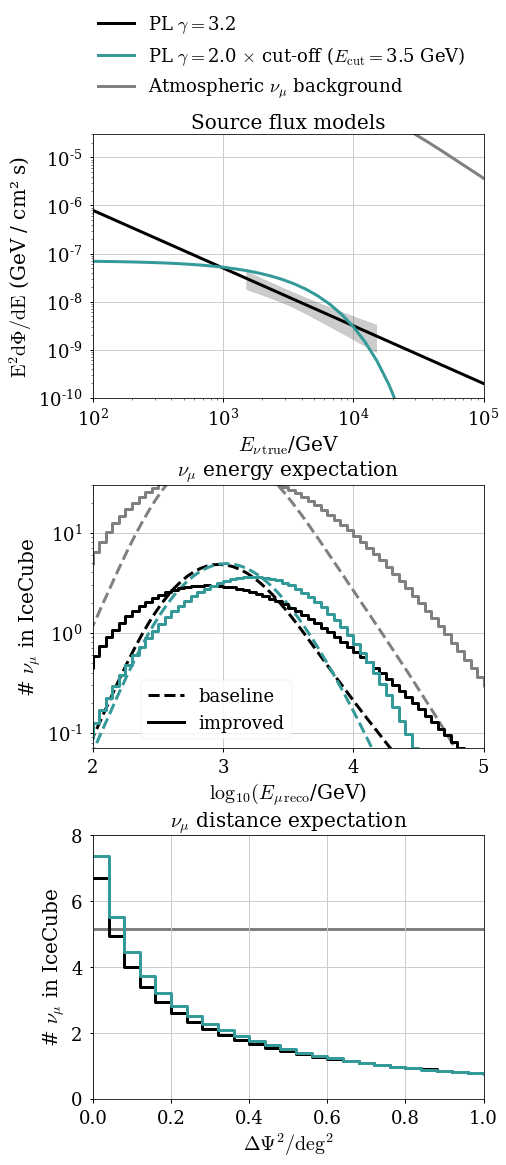

In [20]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=${logE_cut} GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    emids,
    array_source_interp(ngc_src_config["dec"], bckg_vals, sindec_mids)
    * sq_deg
    * (emids**y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 3e-5)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = logE_reco_mids
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):

    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], bckg_vals, sindec_mids),
        normed_kvals=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_flux,
    )

    # cutoff
    k_s_cut = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_cut_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        label=e_name,
        color="k",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )

    ax.plot(
        evals,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        color="#339999",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        color="gray",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"PL source $\nu_\mu$",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"EC source $\nu_\mu$",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"Atmospheric $\nu_\mu$",
    color="gray",
    lw=3, zorder=0
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

f.savefig(join(BASEPATH, f"plots/ngc_spectral_improved_dpsi.pdf"), bbox_inches="tight")


# Set up LLH function

In [21]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# NGC 1068
## Significance test Background vs. Background + Signal

In [22]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_vals, sindec_mids),
        normed_kvals=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        normed_kvals=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))


    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        normed_kvals=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Asimov data sum:
Background: 1156.9207111398587
Signal: 84.4162843142101
Atmo-only normalization: [1.0729609]
Signal fit parameters: [1.  1.  3.2]
TS check: -361542.3076245883 (fit:  -361542.3076245883 )
-2 Delta LLH: 20.310758915322367
P-VALUE: 3.886643793913655e-05 SIGNIFICANCE: 3.9512844196761914

Plenum-1
Asimov data sum:
Background: 4904.034804960723
Signal: 360.54642303528647
Atmo-only normalization: [1.07352032]
Signal fit parameters: [1.  1.  3.2]
TS check: -325148.5384440274 (fit:  -325148.5384440274 )
-2 Delta LLH: 81.51906082133064
P-VALUE: 1.9877458603719084e-18 SIGNIFICANCE: 8.679489498817246

Plenum-2
Asimov data sum:
Background: 12404.03886210967
Signal: 907.8397311525353
Atmo-only normalization: [1.07318905]
Signal fit parameters: [1.  1.  3.2]
TS check: -289055.89816050814 (fit:  -289055.89816050814 )
-2 Delta LLH: 213.12001442280598
P-VALUE: 5.267164432070037e-47 SIGNIFICANCE: 14.350781594239576



## Significance test Background vs. Background + Signal with improved energy resolution

In [84]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    for ef in e_smearing_files:
        # energy smearing matrix
        with open(ef, "rb") as f:
            rgi = pickle.load(f)
        eres = rgi((lre_grid, lge_grid))
        # normalize per bin in true energy
        eres = eres / np.sum(eres, axis=0)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)
        print("- " * 10)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], bckg_vals, sindec_mids),
            normed_kvals=eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            normed_kvals=eres,
            phi_scaling=1,
            flux_shape=ngc_flux,  # powerlaw
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=eres,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


IceCube
artificial
- - - - - - - - - - 
Atmo-only normalization: [1.07296843]
Signal fit parameters: [1.00000551 0.99974757 3.1999844 ]
P-VALUE: 3.846679593092053e-05 SIGNIFICANCE: 3.9537568537231413

energy_smearing_rgi_up.pckl
- - - - - - - - - - 
Atmo-only normalization: [1.07296583]
Signal fit parameters: [1.00002114 0.99932091 3.19962659]
P-VALUE: 3.886652217235375e-05 SIGNIFICANCE: 3.951283901095386

idealized_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.07296652]
Signal fit parameters: [1.00006545 0.99989659 3.19992429]
P-VALUE: 2.5025905267681518e-05 SIGNIFICANCE: 4.055384919143215

improved_0.1_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.07296655]
Signal fit parameters: [1.00005047 1.00014082 3.20006633]
P-VALUE: 2.4632678091365614e-05 SIGNIFICANCE: 4.059085110884277

improved_0.2_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.07296771]
Signal fit parameters: [1.00006426 0.99983157 3.19987831]
P-VALUE: 2.4443915043508138e-05 SIGNIFIC

## Disc. potential vs dec

In [85]:
thresholds = [sigma5]
# idents = ["IceCube"]
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)

tmp = []  # save output here
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)

        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], dec=dec, **bg_config)
            aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], dec=dec, **src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_vals, sindec_mids),
            normed_kvals=baseline_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            baseline_eres,
            1,
            ngc_flux,  # powerlaw
        )
        # calculate an estimate for the flux scaling (black magic)
        scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        count = 0
        while len(current_thresholds) > 0:
            
            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                baseline_eres,
                scaler,
                ngc_flux,  # powerlaw
            )
            k_i = k_s + k_b

            dct = dict(
                shape="powerlaw",
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
                normed_kvals=baseline_eres,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_2d_composite(x, **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_b": np.sum(k_b),
                "n_sig": np.sum(k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(savepath, "ngc_disc_pot.pickle"))


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


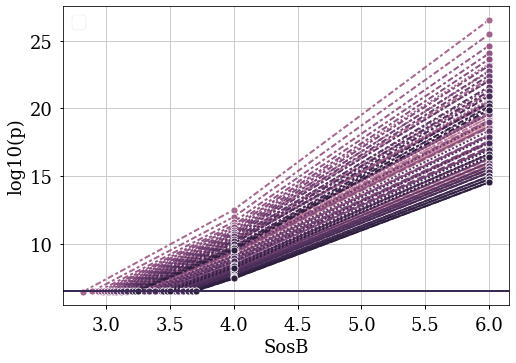

In [86]:
df = pd.DataFrame(tmp)
ax = sns.lineplot(
    data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident"
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)


In [87]:
df = pd.read_pickle(join(savepath, "ngc_disc_pot.pickle"))

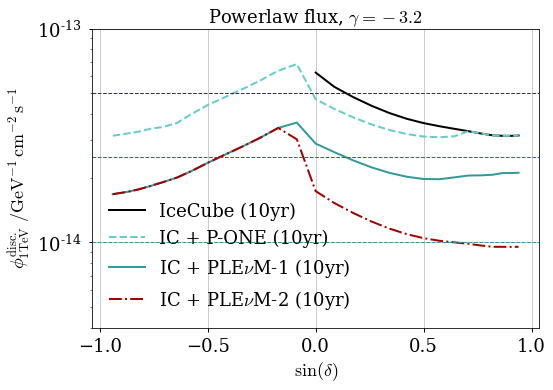

In [88]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0])  # , label="NGC 1068 flux")
ax.axhline(
    PHI_NGC / 2, ls="--", lw=1, color=colorlist[1]
)  # , label="NGC 1068 flux / 2")
ax.axhline(
    PHI_NGC / 5, ls="--", lw=1, color=colorlist[2]
)  # , label="NGC 1068 flux / 5")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend(loc=3, frameon=False)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
ax.set_ylim(4e-15, 1e-13)
f.savefig(join(BASEPATH, "plots/ngc_disc_pot.pdf"), bbox_inches="tight")


## Power law vs. Power-law with cutoff
### normal vs. improved E resolution

In [23]:
# livetime relative to 10yrs
ename= "energy_smearing_rgi_up"
detector_configurations = [
{"key":  "IceCube", "identifier": "10y IC",              "e_file": join(savepath, f'artificial_{ename}.pckl'),              "E_res": "Baseline"},
{"key":  "IceCube", "identifier": "10y IC",              "e_file": join(savepath, f'idealized_artificial_{ename}.pckl'),    "E_res": "Removed bias"},
{"key":  "IceCube", "identifier": "10y IC",              "e_file": join(savepath, f'improved_0.2_artificial_{ename}.pckl'), "E_res": "20% improv."},
{"key":  "IceCube", "identifier": "10y IC",              "e_file": join(savepath, f'improved_0.5_artificial_{ename}.pckl'), "E_res": "50% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": join(savepath, f'artificial_{ename}.pckl'),              "E_res": "Baseline"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": join(savepath, f'idealized_artificial_{ename}.pckl'),    "E_res": "Removed bias"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": join(savepath, f'improved_0.2_artificial_{ename}.pckl'), "E_res": "20% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": join(savepath, f'improved_0.5_artificial_{ename}.pckl'), "E_res": "50% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1",   "e_file": join(savepath, f'artificial_{ename}.pckl'),              "E_res": "Baseline"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1",   "e_file": join(savepath, f'idealized_artificial_{ename}.pckl'),    "E_res": "Removed bias"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1",   "e_file": join(savepath, f'improved_0.2_artificial_{ename}.pckl'), "E_res": "20% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1",   "e_file": join(savepath, f'improved_0.5_artificial_{ename}.pckl'), "E_res": "50% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2",   "e_file": join(savepath, f'artificial_{ename}.pckl'),              "E_res": "Baseline"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2",   "e_file": join(savepath, f'idealized_artificial_{ename}.pckl'),    "E_res": "Removed bias"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2",   "e_file": join(savepath, f'improved_0.2_artificial_{ename}.pckl'), "E_res": "20% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2",   "e_file": join(savepath, f'improved_0.5_artificial_{ename}.pckl'), "E_res": "50% improv."},
]

detector_configurations = pd.DataFrame(detector_configurations)

### Significance

In [90]:
pvals_ngc = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"], sort=False
):
    print(es_ident, identifier)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[series.key.iloc[0]], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[series.key.iloc[0]], **ngc_src_config)
    ## add the other detector configs to IceCube
    if series.key.iloc[0] != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        rgi = pickle.load(f)
    eres = rgi((lre_grid, lge_grid))
    # normalize per bin in true energy
    eres = eres / np.sum(eres, axis=0)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], bckg_vals, sindec_mids),
        normed_kvals=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_cut_flux,  # powerlaw with cutoff
    )
    k_i = k_s + k_b

    if ii == 0:
        print("Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s))
    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
        normed_kvals=eres,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, Gamma_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(savepath, "ngc_performance_cut_eres.pickle"))


Baseline 10y IC
/home/lisajsch/repos/Plenum/local/artificial_energy_smearing_rgi_up.pckl
Asimov data sum: Background = 1156.920711139858 , Signal = 84.4162843142101
bckg params: [0.99380574 1.08957414 3.22809613]
global params: [1.00389493 1.14423841 1.85955466 3.52945068]
true params: (1, 1.4271729213706608, 2.0, 3.5)
P-VALUE: 0.43389344789121953 SIGNIFICANCE: 0.16647024715304265
pval check: 0.4092459121801536 ratio: 0.9431944966423064

Removed bias 10y IC
/home/lisajsch/repos/Plenum/local/idealized_artificial_energy_smearing_rgi_up.pckl
Asimov data sum: Background = 1156.9207111398584 , Signal = 84.41628431421013
bckg params: [0.99746456 1.0038891  3.11258683]
global params: [1.00027242 1.45098156 1.94202851 3.47260214]
true params: (1, 1.4271729213706608, 2.0, 3.5)
P-VALUE: 0.06430439637030777 SIGNIFICANCE: 1.5196109160632896
pval check: 0.06421504770467405 ratio: 0.9986105356604362

20% improv. 10y IC
/home/lisajsch/repos/Plenum/local/improved_0.2_artificial_energy_smearing_rgi_up.

### Nice significance summary plot

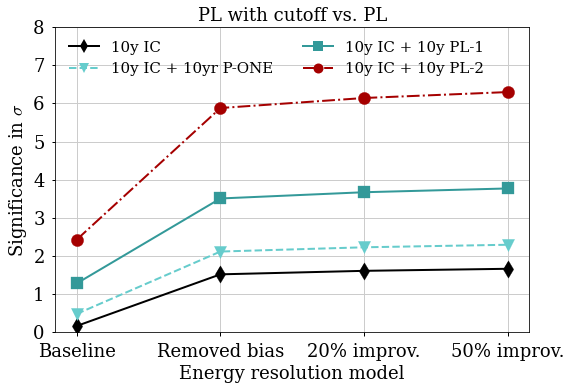

In [91]:
pval_df = pd.read_pickle(join(savepath, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
label_size = "x-small"
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 8)
ax.legend(loc=2, ncol=2, frameon=False, fontsize=15)
ax.set_title("PL with cutoff vs. PL", fontsize=18)
ax.set_xlabel("Energy resolution model", fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$", fontsize=18)
f.tight_layout()
f.savefig("../../plots/cutoff_sigma_vs_eres_ngc.pdf")


## spectral fit vs. dec

scan for right threshold

In [69]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        dec = dec
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **bg_config
            )
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **src_config
            )

        # asimov data
        # improved energy resolution
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_vals, sindec_mids),
            normed_kvals=improved_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            normed_kvals=improved_eres,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )
        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                normed_kvals=improved_eres,
                phi_scaling=scaler,
                flux_shape=ngc_cut_flux,
            )
            k_i = k_s + k_b

            dct = dict(
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm, 
                normed_kvals=improved_eres,
            )
            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_2d_composite(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_sig": np.sum(k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(savepath, "ngc_spectral_disc_pot.pickle"))


100%|██████████| 37/37 [01:56<00:00,  3.15s/it]


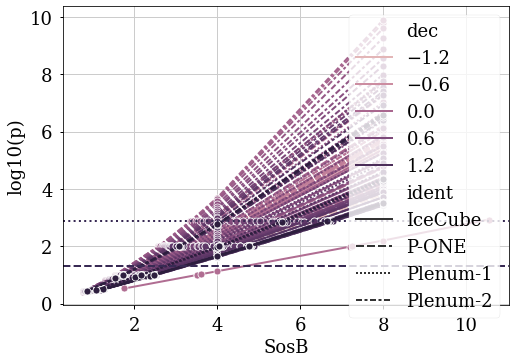

In [73]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB" # "scaler" # 
ax = sns.lineplot(
    data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
plt.axhline(-np.log10(sigma3), ls=":")
plt.axhline(-np.log10(0.05), ls="--")
plt.legend()

## plotting


In [70]:
df = pd.read_pickle(join(savepath, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * ngc_cut_flux.norm
flux["5%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05)) * ngc_cut_flux.norm
flux["10%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm


### plot various thresholds

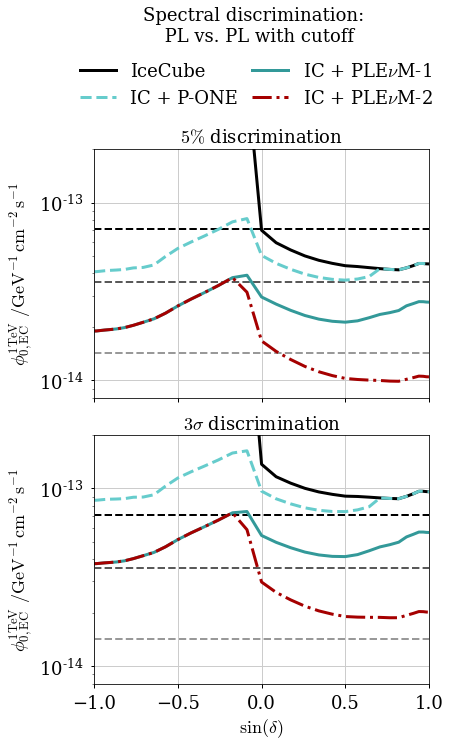

In [75]:
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby(["ident"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3, 
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    #fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig("../../plots/ngc_spectral_disc_pot.pdf", bbox_inches="tight")


In [ ]:
raise BaseException(":)")

BaseException: :)

## cross check with paper, gamma=-2


In [127]:
ident = "IceCube"
decs = np.arange(0, 71, step=15)
gamma2_flux = PL_flux(1E-15, 2.0, E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [sigma5]
for eres, name in zip([baseline_eres, improved_eres], ["base", "improved"]):
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)
        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_vals, sindec_mids),
            normed_kvals=eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            eres,
            1,
            gamma2_flux,  # powerlaw
        )
        # calculate an estimate for the flux scaling
        scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:
            

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                eres,
                scaler,
                gamma2_flux,  # powerlaw
            )
            k_i = k_s + k_b

            dct = dict(
                shape="powerlaw",
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=gamma2_flux.E0,
                phi_0=gamma2_flux.norm,
                normed_kvals=eres,
            )

            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_2d_composite(x, **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 1.2, 3.0),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "eres": name,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_b": np.sum(k_b),
                "n_sig": np.sum(k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)

            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(savepath, "gamma2_disc_pot.pickle"))


 60%|██████    | 3/5 [00:08<00:06,  3.13s/it]

Optimization failed! Diff is: 0.2451056294824454 thresh is: 2.866515719235352e-07


 80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

Optimization failed! Diff is: 0.2922810482915068 thresh is: 2.866515719235352e-07


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

Optimization failed! Diff is: 0.36098634177234334 thresh is: 2.866515719235352e-07


In [128]:
flux = pd.DataFrame(
    df.groupby(["eres", "dec"]).apply(lambda x: get_scaler(x, sigma5))
    * gamma2_flux.norm,
    columns=["disc5"],
).reset_index()


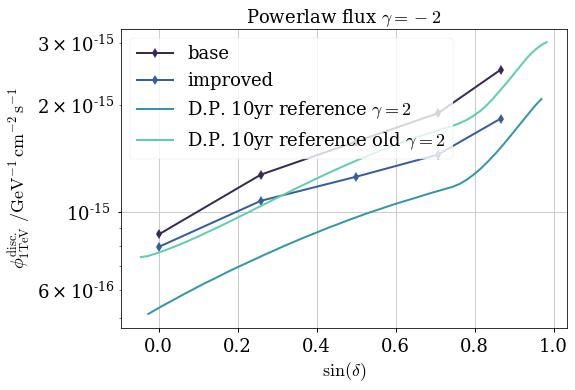

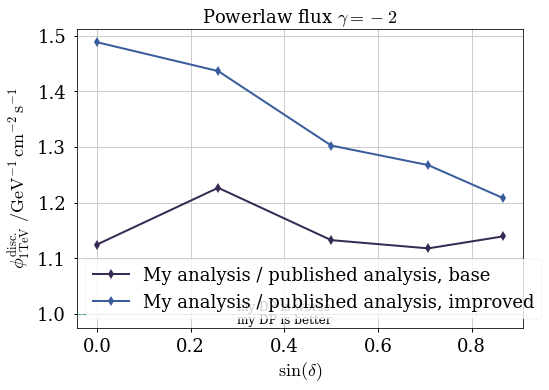

In [133]:
# comparison to DP from ngc paper

ps_disc_old = np.genfromtxt(
    "/home/lisajsch/repos/Plenum/local/ngc_DP_old_gamma-2.txt", delimiter=","
)
ps_disc = np.genfromtxt(
    "/home/lisajsch/repos/Plenum/local/ngc_DP_gamma-2.txt", delimiter=","
)

ind_disc = np.argsort(ps_disc[:, 0])
xsd = ps_disc[:, 0][ind_disc]
ic_10yr = ps_disc[:, 1][ind_disc]
spl_10yr = splrep(xsd, ic_10yr)

ind_disc_old = np.argsort(ps_disc_old[:, 0])
xsd_old = ps_disc_old[:, 0][ind_disc_old]
ic_10yr_old = ps_disc_old[:, 1][ind_disc_old]
spl_10yr_old = splrep(xsd_old, ic_10yr_old)

gamma = 2
ident = "IceCube"

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        label=eres,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
    )

ax.plot(xsd, ic_10yr * 1e-15, label=rf"D.P. 10yr reference $\gamma={gamma}$")
ax.plot(
    xsd_old, ic_10yr_old * 1e-15, label=rf"D.P. 10yr reference old $\gamma={gamma}$"
)

ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
# ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot.pdf", bbox_inches="tight")

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    cur = spl_10yr if eres=="improved" else spl_10yr_old
    plt.plot(
        np.sin(series.dec),
        series.disc5 / splev(np.sin(series.dec), cur) * 1e15,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
        label="My analysis / published analysis, " + eres,
    )
plt.axhline(1, ls="--", lw=1, color="#339999")
plt.text(0.3, 1.0, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.0, "my DP is worse", va="bottom", fontsize=12)
ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot_ratio.pdf", bbox_inches="tight")
